## Прогнозирование уровня средней заработной платы в России

Для выполнения этого задания вам понадобятся данные о среднемесячных уровнях заработной платы в России: WAG_C_M.csv

В файле записаны данные о заработной плате за каждый месяц с января 1993 по август 2016. Если хотите, можете дописать в конец ряда данные за следующие месяцы, если они уже опубликованы; найти эти данные можно, например, [здесь](http://sophist.hse.ru/exes/tables/WAG_M.htm).

Необходимо проанализировать данные, подобрать для них оптимальную прогнозирующую модель в классе ARIMA и построить прогноз на каждый месяц на два года вперёд от конца данных.

Придерживайтесь стандартного алгоритма построения прогноза:

1. Визуальный анализ ряда

2. Стабилизация дисперсии (при необходимости)
3. Выбор порядка дифференцирования
4. Выбор начальных приближений для $p,q,P,Q$
5. Обучение и сравнение моделей-кандидатов, выбор победителя
6. Анализ остатков построенной модели, при необходимости — её модификация: если остатки получаются смещёнными, прогноз нужно скорректировать на константу; если остатки нестационарны или автокоррелированы, можно попробовать расширить область, в которой подбираются значения $p,q,P,Q$.
7. Прогнозирование с помощью финальной модели.

In [1]:
import pandas as pd
import numpy as np
from scipy import stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
import itertools

%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
data = pd.read_csv('WAG_C_M.csv', sep=';', index_col='month', parse_dates=['month'], dayfirst=True)
data.columns = ['WAG']
data.head()

,WAG
month,
1993-01-01,15.3
1993-02-01,19.1
1993-03-01,23.6
1993-04-01,30.6
1993-05-01,37.5


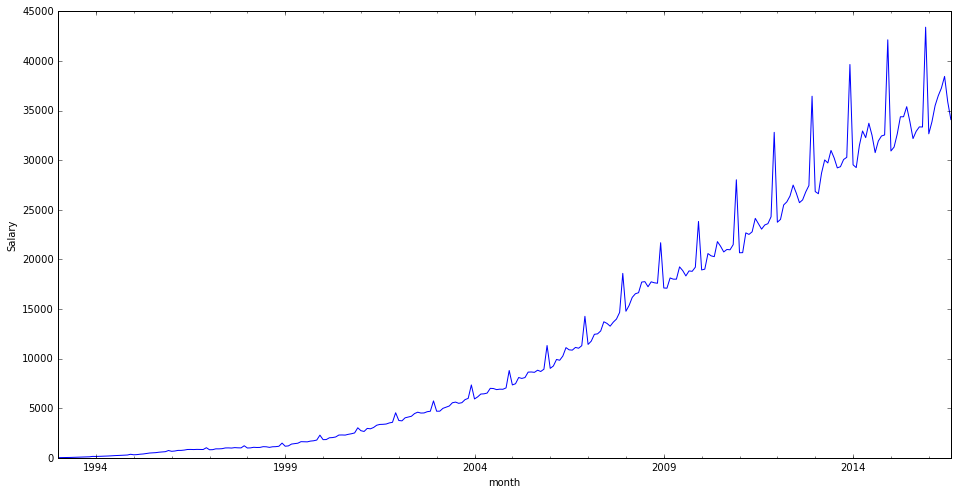

In [3]:
plt.figure(figsize(16,8))
data.WAG.plot()
plt.ylabel('Salary')
pylab.show()

Наблюдается сезонность, есть тренд, нестационарная дисперсия.

Проверка стационарности ряда: 

In [4]:
print "Dickey-Fuller test, p-value: ", sm.tsa.stattools.adfuller(data.WAG)[1]

Dickey-Fuller test, p-value:  0.991849595485


STL-декомпозиция ряда: 

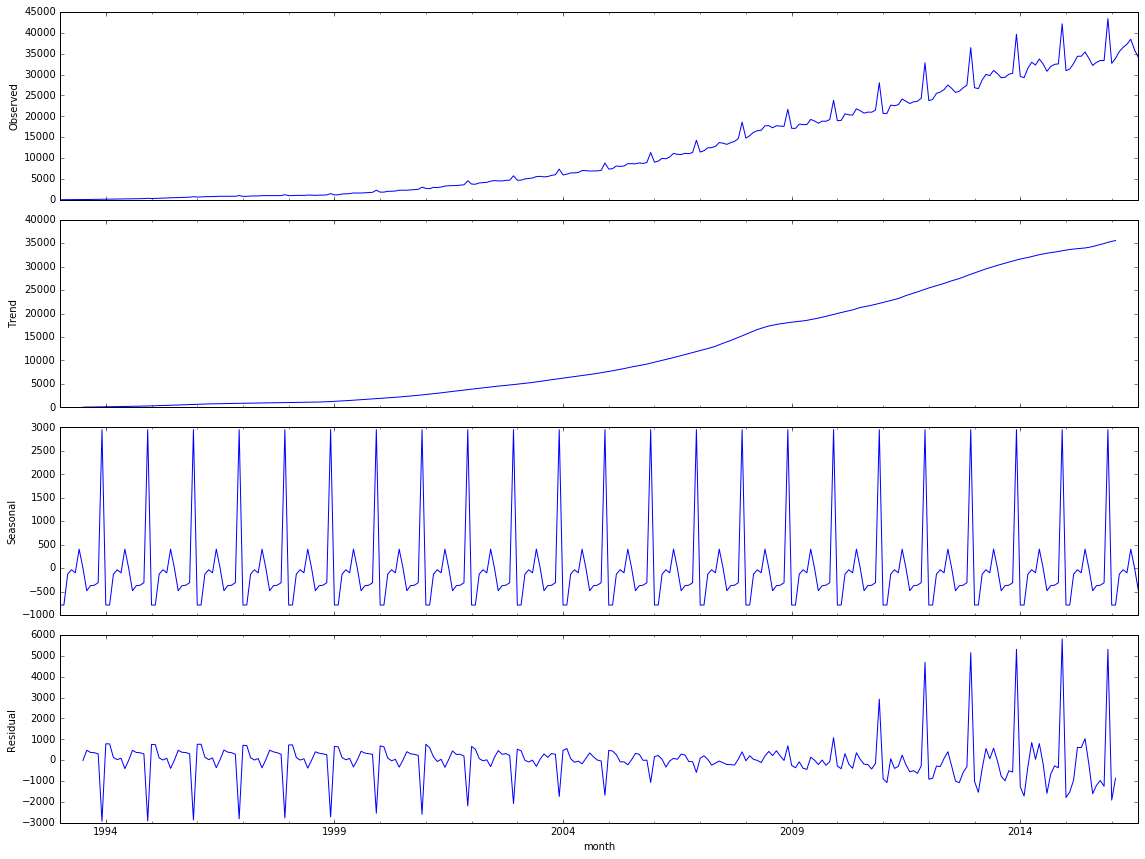

In [5]:
plt.figure(figsize(16,12))
sm.tsa.seasonal_decompose(data.WAG).plot()
pylab.show()

### Стабилизация дисперсии

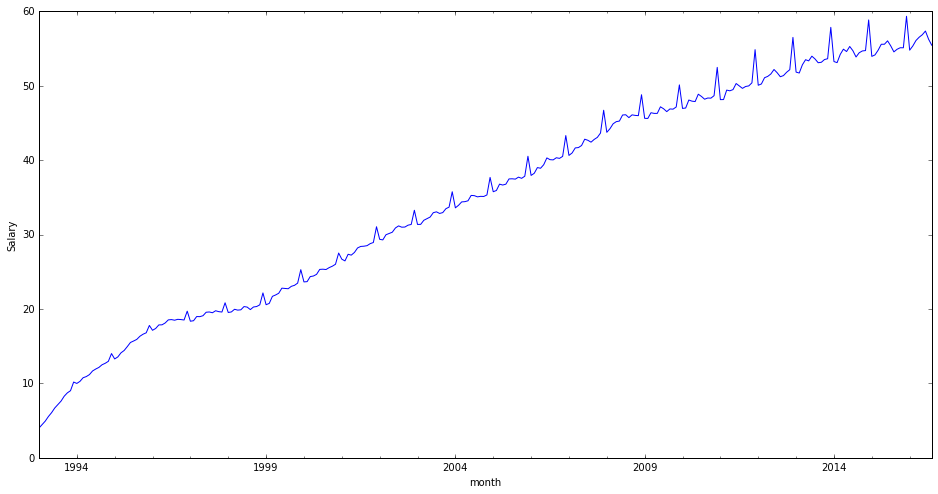

In [6]:
data['WAG_boxcox'], lmbda = stats.boxcox(data.WAG)
plt.figure(figsize = (16,8))
data.WAG_boxcox.plot()
plt.ylabel('Salary')
pylab.show()

In [7]:
print "Box-Cox transformation, parameter: %f" % lmbda
print "Dickey-Fuller test, p-value:", sm.tsa.stattools.adfuller(data.WAG_boxcox)[1]

Box-Cox transformation, parameter: 0.263202
Dickey-Fuller test, p-value: 0.696898763483


### Стационарность

Критерий Дики-Фуллера не отвергает нулевую гипотезу о нестационарности ряда. Проведем сезонное дифференцирование. 

In [8]:
data['WAG_boxcox_diff_season'] = data.WAG_boxcox - data.WAG_boxcox.shift(12)
print "Dickey-Fuller test, p-value:", sm.tsa.stattools.adfuller(data.WAG_boxcox_diff_season.dropna())[1]

Dickey-Fuller test, p-value: 0.0146971334948


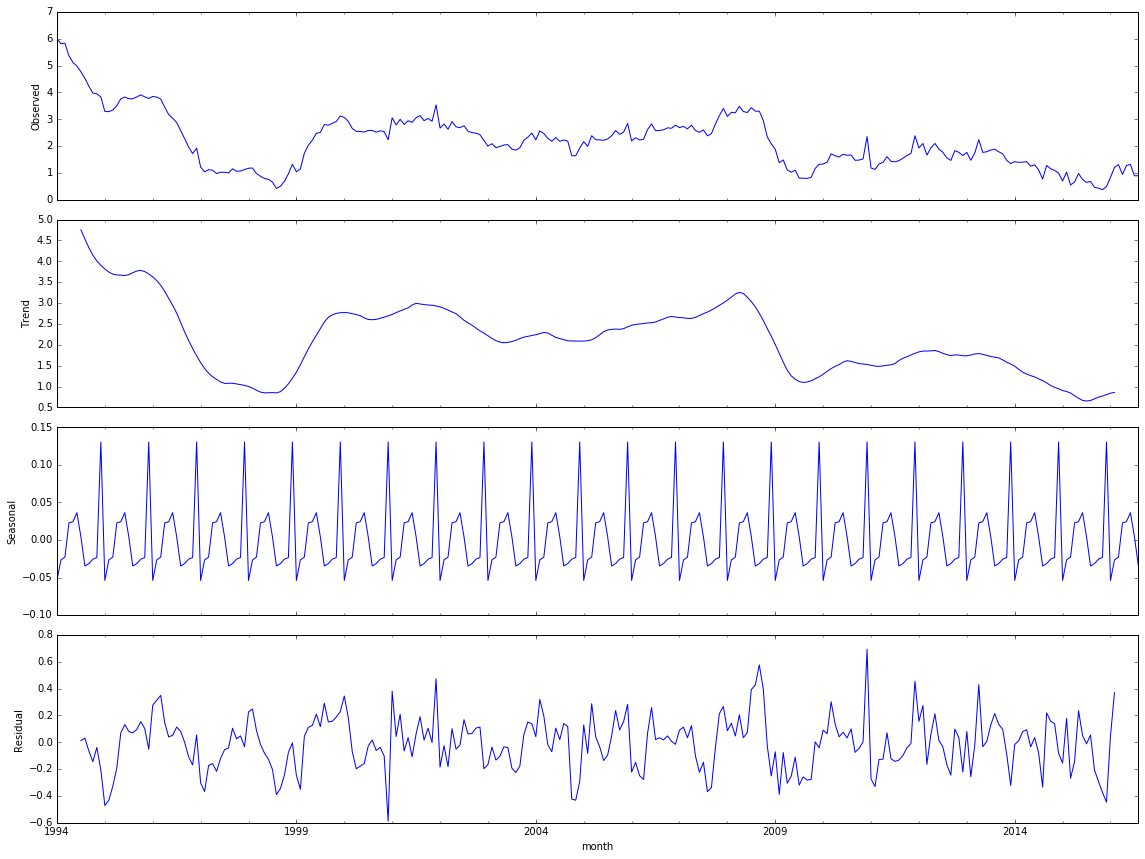

In [9]:
plt.figure(figsize(16,12))
sm.tsa.seasonal_decompose(data.WAG_boxcox_diff_season.dropna()).plot()
pylab.show()

Критерий Дики-Фуллера отвергает гипотезу, однако полностью от тренда избавиться не удалось. Попробуем применить обычное дифференцирование. 

In [10]:
data['WAG_boxcox_diff2'] = data.WAG_boxcox_diff_season - data.WAG_boxcox_diff_season.shift(1)
print "Dickey-Fuller test, p-value:", sm.tsa.stattools.adfuller(data.WAG_boxcox_diff2.dropna())[1]

Dickey-Fuller test, p-value: 5.20360371582e-08


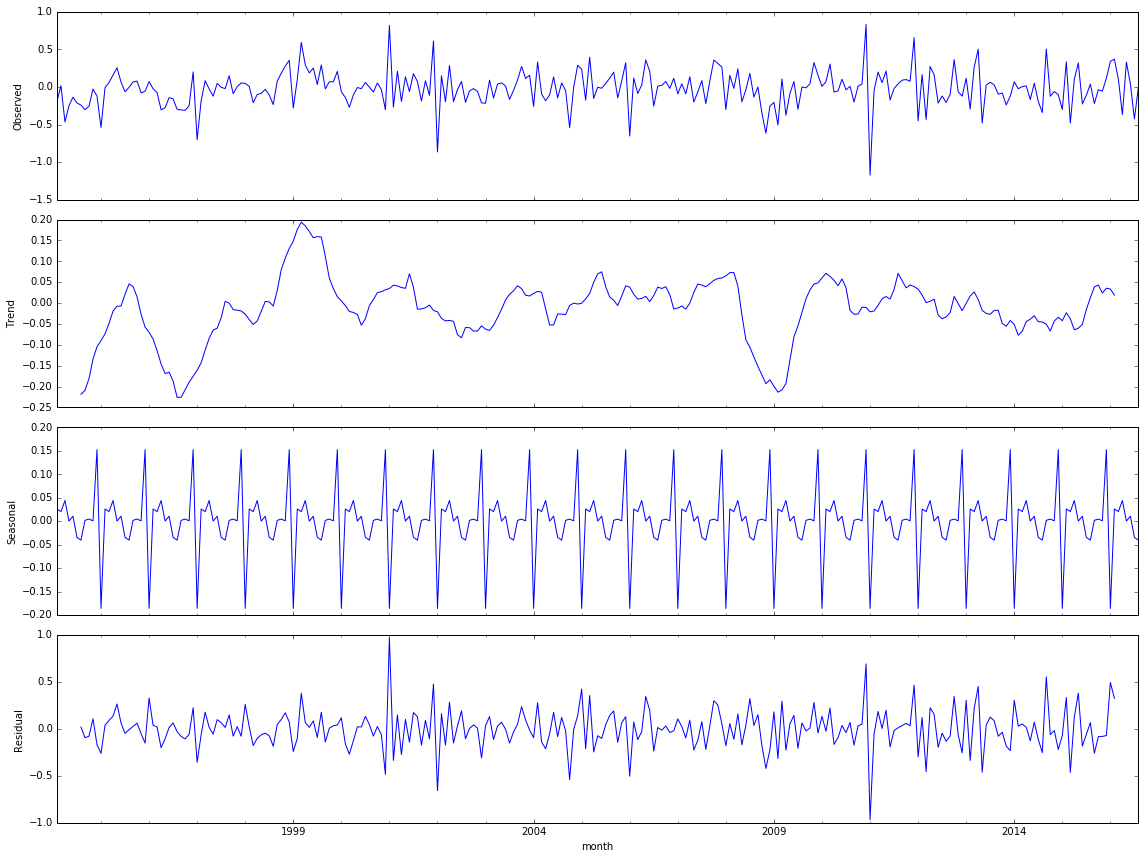

In [11]:
plt.figure(figsize(16,12))
sm.tsa.seasonal_decompose(data.WAG_boxcox_diff2.dropna()).plot()
pylab.show()

Применим еще раз обычное дифференцирование:

In [12]:
data['WAG_boxcox_diff3'] = data.WAG_boxcox_diff2 - data.WAG_boxcox_diff2.shift(1)
print "Dickey-Fuller test, p-value:", sm.tsa.stattools.adfuller(data.WAG_boxcox_diff3.dropna())[1]

Dickey-Fuller test, p-value: 1.01595554196e-13


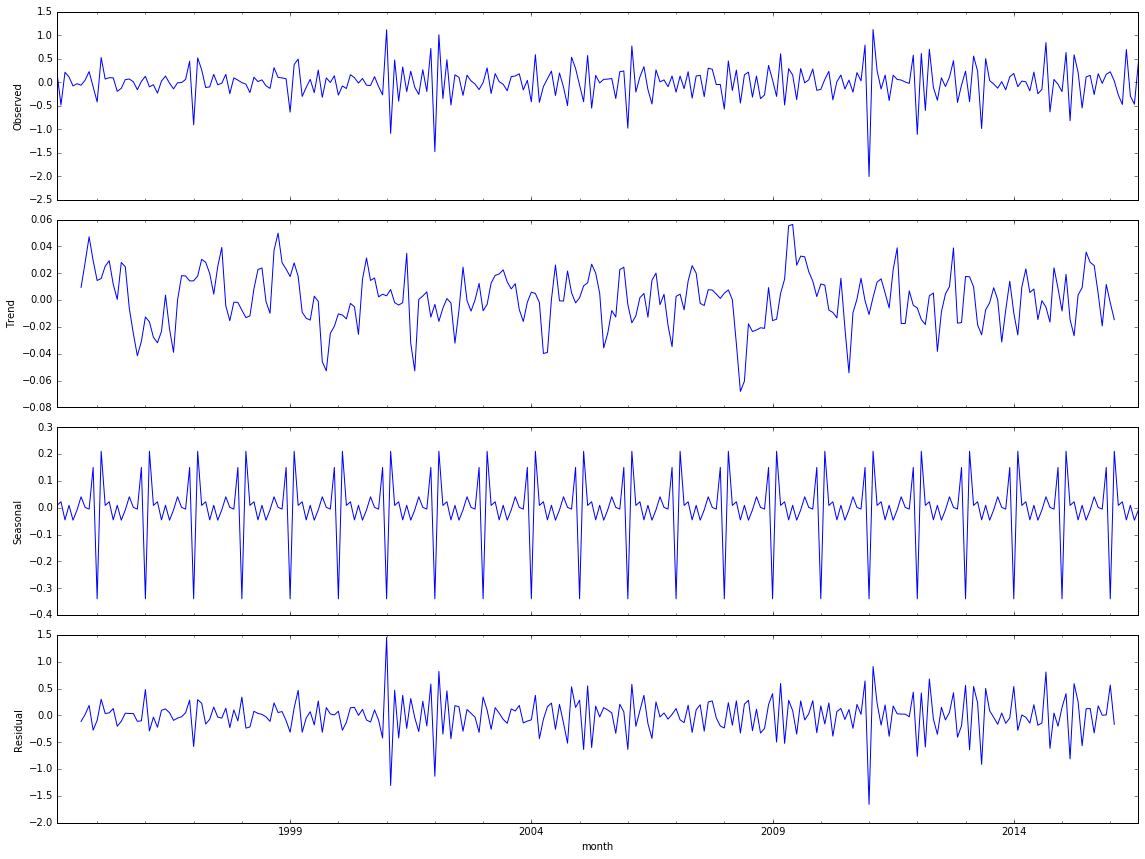

In [13]:
plt.figure(figsize(16,12))
sm.tsa.seasonal_decompose(data.WAG_boxcox_diff3.dropna()).plot()
pylab.show()

Гипотеза о нестационарности отвергается и тренда больше нет.

### Выбор начальных приближений

Посмотрим на ACF и PACF ряда:

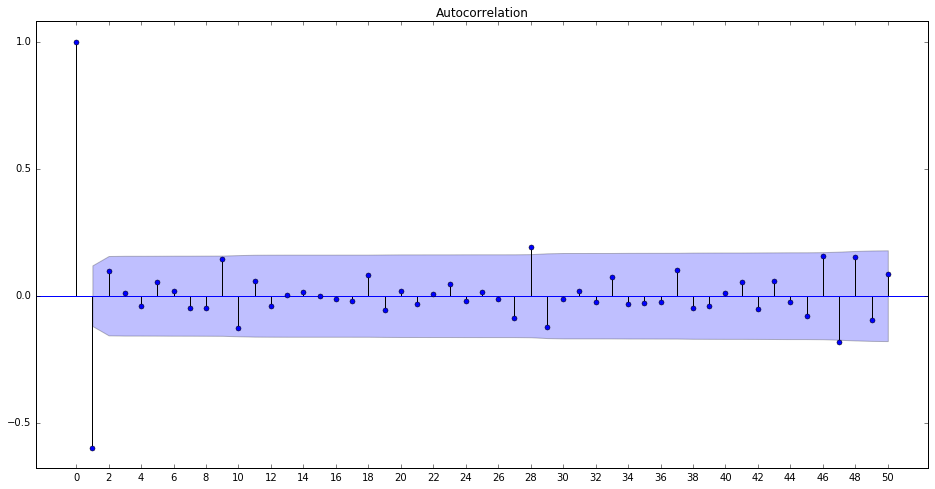

In [14]:
plt.figure(figsize(16,8))
sm.graphics.tsa.plot_acf(data.WAG_boxcox_diff3.dropna().values.squeeze(), lags=50)
plt.xticks(np.arange(0, 51, 2))
pylab.show()

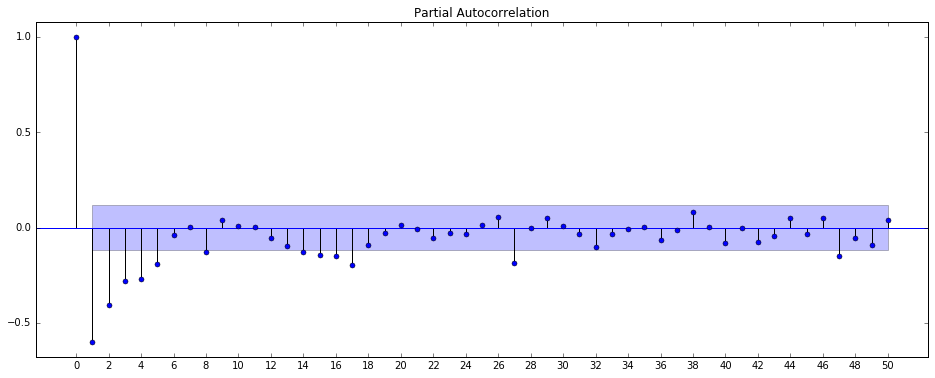

In [15]:
plt.figure(figsize(16,6))
sm.graphics.tsa.plot_pacf(data.WAG_boxcox_diff3.dropna().values.squeeze(), lags=50)
plt.xticks(np.arange(0, 51, 2))
pylab.show()

Начальные приближения: $Q=0, q = 1, P = 0, p = 5, d = 2, D = 1$

In [16]:
Qs = [0]
qs = range(0, 2)

Ps = [0]
ps = range(0, 6)

d = 2
D = 1

### Выбор модели

In [17]:
parameters = itertools.product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

12

In [18]:
%%time
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')

for param in parameters_list:
    try:
        model=sm.tsa.statespace.SARIMAX(data.WAG_boxcox, order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 12)).fit(disp=-1)
    except ValueError:
        print 'wrong parameters:', param
        continue
    aic = model.aic
    
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])
    
warnings.filterwarnings('default')

wrong parameters: (0, 0, 0, 0)
Wall time: 6.09 s


In [19]:
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print result_table.sort_values(by = 'aic', ascending=True).head()

      parameters        aic
10  (5, 1, 0, 0)   4.799961
2   (1, 1, 0, 0)   7.646883
6   (3, 1, 0, 0)   8.441778
4   (2, 1, 0, 0)   9.186738
0   (0, 1, 0, 0)  12.067277


In [20]:
print best_model.summary()

                                 Statespace Model Results                                 
Dep. Variable:                         WAG_boxcox   No. Observations:                  284
Model:             SARIMAX(5, 2, 1)x(0, 1, 0, 12)   Log Likelihood                   4.600
Date:                            Sun, 02 Oct 2016   AIC                              4.800
Time:                                    02:57:23   BIC                             30.343
Sample:                                01-01-1993   HQIC                            15.041
                                     - 08-01-2016                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1504      0.052     -2.878      0.004      -0.253      -0.048
ar.L2          0.0660      0.070   

### Анализ остатков

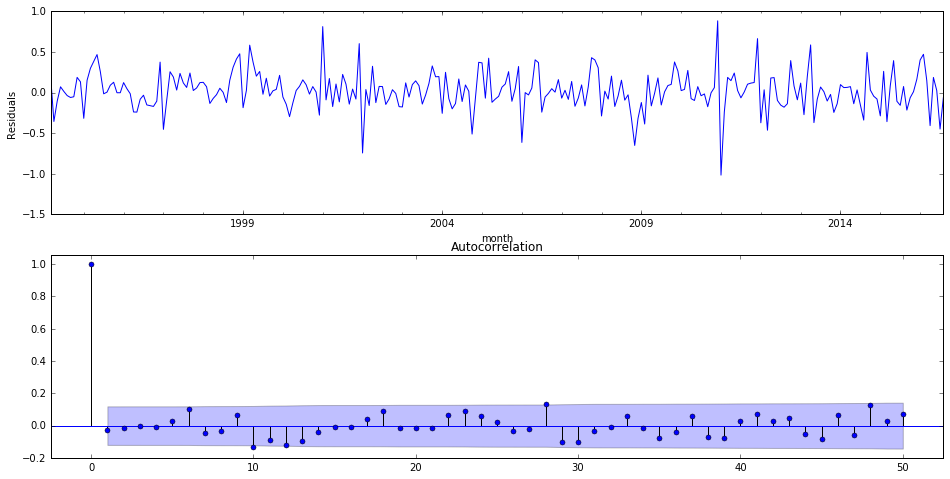

In [21]:
plt.figure(figsize(16,8))
plt.subplot(211)
best_model.resid[14:].plot()
plt.ylabel(u'Residuals')

ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(best_model.resid[14:].values.squeeze(), lags=50, ax=ax)
pylab.show()

In [22]:
print "Student's t-test, p-value:", stats.ttest_1samp(best_model.resid[14:], 0)[1]
print "Dickey-Fuller test, p-value:", sm.tsa.stattools.adfuller(best_model.resid[14:])[1]

Student's t-test, p-value: 0.093800887735
Dickey-Fuller test, p-value: 1.19366809475e-29


Остатки несмещены (подтверждается критерием Стьюдента), стационарны (подтверждается критерием Дики-Фуллера и визуально), неавтокоррелированы (подтверждается критерием Льюнга-Бокса, p-value=0.16, и коррелограммой).

In [23]:
def invboxcox(y,lmbda):
   if lmbda == 0:
      return(np.exp(y))
   else:
      return(np.exp(np.log(lmbda*y+1)/lmbda))

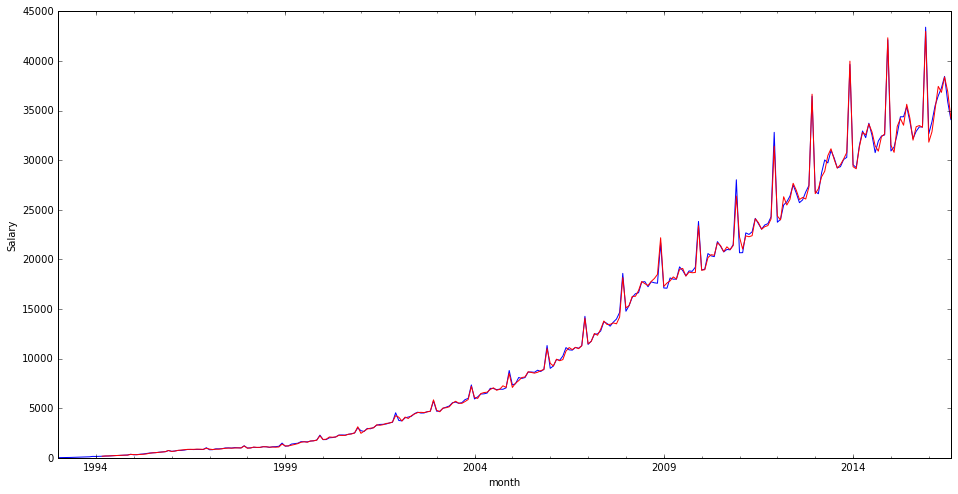

In [24]:
data['model'] = invboxcox(best_model.fittedvalues, lmbda)

plt.figure(figsize(16,8))
data.WAG.plot()
data.model[14:].plot(color='r')
plt.ylabel('Salary')
pylab.show()

Построенная модель хорошо описывает данные, попробуем сделать прогноз на два года вперед. 

### Прогнозирование

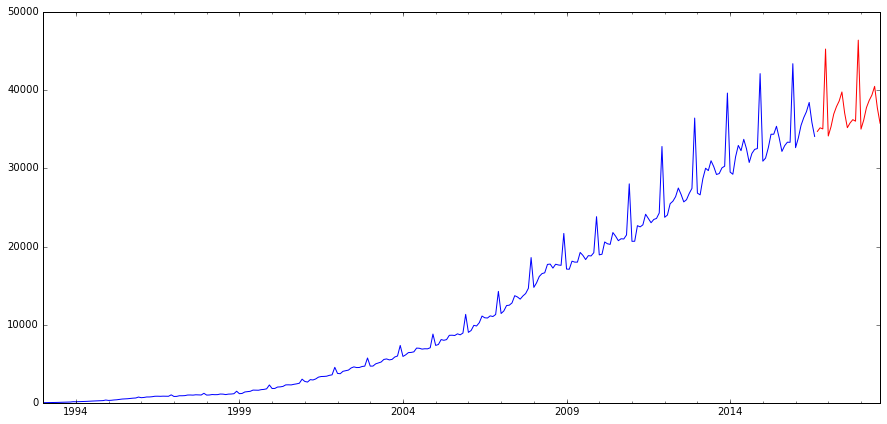

In [25]:
data_model = data[['WAG']]
future_date = [datetime.datetime.strptime("2016-09-01", "%Y-%m-%d") + relativedelta(months=x) for x in range(0,24)]
future = pd.DataFrame(index = future_date, columns = data_model.columns)
data_model = pd.concat([data_model, future])
data_model['forecast'] = invboxcox(best_model.predict(start=284, end=307), lmbda)

plt.figure(figsize(15,7))
data_model.WAG.plot()
data_model.forecast.plot(color='r')
pylab.show()